In [341]:
import pandas as pd
import numpy as np
import random
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)
# Right after importing seaborn (could also use 'whitegrid')
sns.set_theme(style='darkgrid', context='talk')

import warnings
warnings.filterwarnings('ignore')

from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error
from numpy import sqrt
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [342]:
data=pd.read_csv('data_cleaned.csv', parse_dates=['date'], index_col=0)
data.head()

,order_id,date,item_code,quantity,unit_price_vat_excl,unit_cogs,net_revenue,gross_revenue,margin_revenue,country,item_name,style,name,group0,group1,category
0,1900052301.000,2019-06-04,ZB00025746,1,9.412,0.000,9.412,0.000,9.412,Romania,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
1,1900100835.000,2019-07-15,ZB00025746,1,8.649,5.393,8.649,5.393,3.255,Czech Republic,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
2,1900106577.000,2019-07-24,ZB00025746,1,8.649,5.459,8.649,5.459,3.190,Czech Republic,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
3,1900111398.000,2019-08-01,ZB00025746,1,8.649,5.440,8.649,5.440,3.209,Czech Republic,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
4,1900052301.000,2019-06-04,ZB00022010,1,12.785,4.088,12.785,4.088,8.697,Romania,NK MERC LT GRD,sp2120-703,Nike,Equipment,Guards,football


In [299]:
data_czech=data[data['country']=='Czech Republic']
data_czech.shape

(498832, 16)

In [300]:
data_shoes=data_czech[data_czech['group1']=='Running shoes']
data_shoes.head()

,order_id,date,item_code,quantity,unit_price_vat_excl,unit_cogs,net_revenue,gross_revenue,margin_revenue,country,item_name,style,name,group0,group1,category
488349,1900078405.000,2019-06-04,ZB00025791,1,73.996,0.000,73.996,0.000,73.996,Czech Republic,NIKE ODYSSEY REACT 2 FLYKNIT,ah1015-003,Nike,Footwear,Running shoes,running
488366,1900086051.000,2019-06-17,ZB00023061,1,107.598,0.000,107.598,0.000,107.598,Czech Republic,UltraBOOST 19,b37707,adidas,Footwear,Running shoes,running
488367,1900106717.000,2019-07-25,ZB00023061,1,107.598,52.540,107.598,52.540,55.059,Czech Republic,UltraBOOST 19,b37707,adidas,Footwear,Running shoes,running
488368,2000023084.000,2020-01-25,ZB00023061,1,115.286,52.540,115.286,52.540,62.747,Czech Republic,UltraBOOST 19,b37707,adidas,Footwear,Running shoes,running
488491,1900085863.000,2019-06-14,ZB00005936,1,44.942,41.944,44.942,41.944,2.998,Czech Republic,ASICS GEL-PULSE 10,1011a007-021,Asics,Footwear,Running shoes,running


In [301]:
def select_series(data, time_period='day', revenue='net'):
    time_periods = {
        'day': 'D',
        'week': 'W',
        'month': 'M'}
    
    revenue_cat = {
        'net':'net_revenue',
        'gross':'gross_revenue',
        'margin':'margin_revenue'}
    
    data = data.set_index('date')
    data = data[revenue_cat[revenue]].resample(time_periods[time_period]).sum()
    data = pd.DataFrame(data).reset_index()
    return data

In [302]:
daily_sales=select_series(data_shoes)
daily_sales.columns=['ds', 'y']
daily_sales.ds=pd.to_datetime(daily_sales['ds'])
daily_sales.sort_values('ds')
daily_sales.head()

,ds,y
0,2019-06-01,422.736
1,2019-06-02,89.596
2,2019-06-03,147.287
3,2019-06-04,6270.933
4,2019-06-05,9909.891


In [303]:
daily_sales.to_csv(r'runningshoes_dailysales.csv')

In [304]:
sales=pd.read_csv('runningshoes_dailysales.csv')
sales=sales.drop(['Unnamed: 0'], axis=1)
sales.columns=['date', 'sales']
sales.head()

,date,sales
0,2019-06-01,422.736
1,2019-06-02,89.596
2,2019-06-03,147.287
3,2019-06-04,6270.933
4,2019-06-05,9909.891


In [305]:
# convert date column to datatime object
sales['date'] = pd.to_datetime(sales['date'], format='%Y-%m-%d') 


# Create Date-related Features for EDA and modeling
sales['year'] = sales['date'].dt.year
sales['month'] = sales['date'].dt.month
sales['day'] = sales['date'].dt.day
sales['weekday'] = sales['date'].dt.weekday
sales['weekday'] = np.where(sales.weekday == 0, 7, sales.weekday)
sales.head()

,date,sales,year,month,day,weekday
0,2019-06-01,422.736,2019,6,1,5
1,2019-06-02,89.596,2019,6,2,6
2,2019-06-03,147.287,2019,6,3,7
3,2019-06-04,6270.933,2019,6,4,1
4,2019-06-05,9909.891,2019,6,5,2


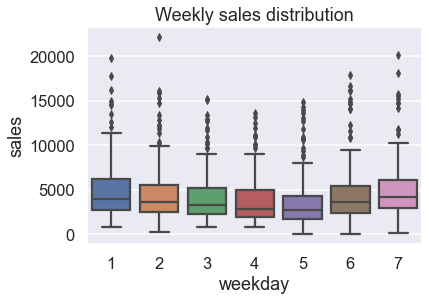

In [306]:
#let's find out the usual sales during a week

plot = sns.boxplot(x='weekday', y='sales', data=sales)
_ = plot.set(title='Weekly sales distribution')

#### It seems like the sales peak is on Sundays (day 7), and it is followed by Mondays.

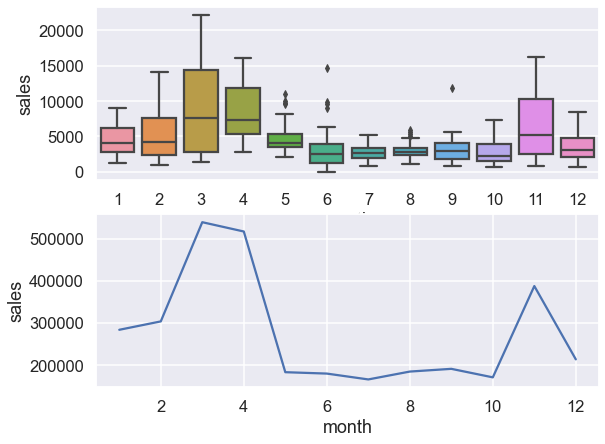

In [308]:
# let's see how monthly sales looks like in a year. 
monthly_agg = sales.groupby('month')['sales'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sns.boxplot(x='month', y='sales', data=sales, ax=axs[0])
_ = sns.lineplot(x='month', y='sales', data=monthly_agg, ax=axs[1])

In [309]:

train_df=daily_sales[:int(daily_sales.shape[0]*0.8)]

test_df=daily_sales[int(daily_sales.shape[0]*0.8):]
print(train_df.shape)
print(test_df.shape)

(565, 2)
(142, 2)


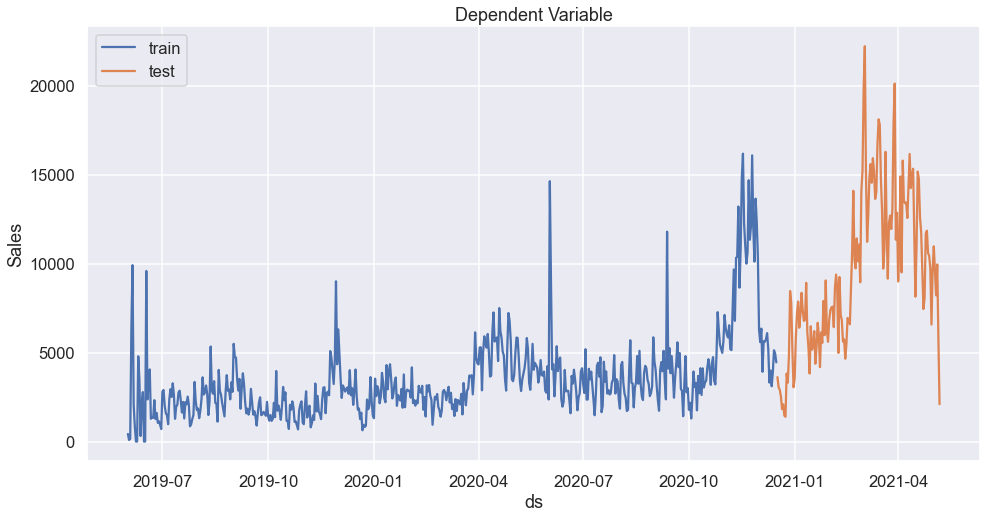

In [310]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(x='ds', y='y', label='train', data=train_df, ax=ax)
sns.lineplot(x='ds', y='y', label='test', data=test_df, ax=ax)

ax.legend(loc='upper left')
ax.set(title='Dependent Variable', ylabel='Sales');

In [311]:
#training the model on training set
model=Prophet(weekly_seasonality=True, daily_seasonality=False, n_changepoints=3)
model.add_seasonality(name='monthly', period=30, fourier_order=1)
model.fit(train_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [312]:
future=model.make_future_dataframe(periods=172, freq='D')
forecast=model.predict(future)

In [313]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-06-01,1876.049,-1226.925,3595.268,1876.049,1876.049,-535.173,-535.173,-535.173,213.130,213.130,213.130,-748.304,-748.304,-748.304,0.000,0.000,0.000,1340.875
1,2019-06-02,1880.659,-22.562,4438.349,1880.659,1880.659,244.210,244.210,244.210,243.349,243.349,243.349,0.861,0.861,0.861,0.000,0.000,0.000,2124.869
2,2019-06-03,1885.268,504.448,5283.717,1885.268,1885.268,996.011,996.011,996.011,262.932,262.932,262.932,733.079,733.079,733.079,0.000,0.000,0.000,2881.280
3,2019-06-04,1889.878,231.652,5030.915,1889.878,1889.878,749.901,749.901,749.901,271.024,271.024,271.024,478.877,478.877,478.877,0.000,0.000,0.000,2639.780
4,2019-06-05,1894.488,15.958,4728.954,1894.488,1894.488,486.747,486.747,486.747,267.271,267.271,267.271,219.476,219.476,219.476,0.000,0.000,0.000,2381.235


In [314]:
# We want to look at yhat, yhat_lower, and yhat_upper only. 
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2019-06-01,1340.875,-1226.925,3595.268
1,2019-06-02,2124.869,-22.562,4438.349
2,2019-06-03,2881.280,504.448,5283.717
3,2019-06-04,2639.780,231.652,5030.915
4,2019-06-05,2381.235,15.958,4728.954


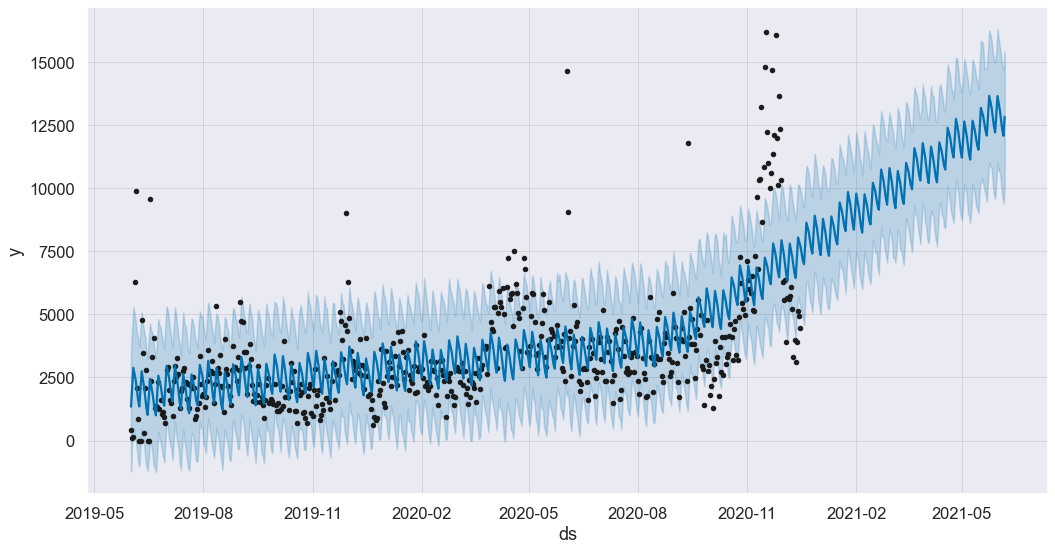

In [315]:
#ploting the forecast
f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)

fig=model.plot(forecast, ax=ax)
plt.show()

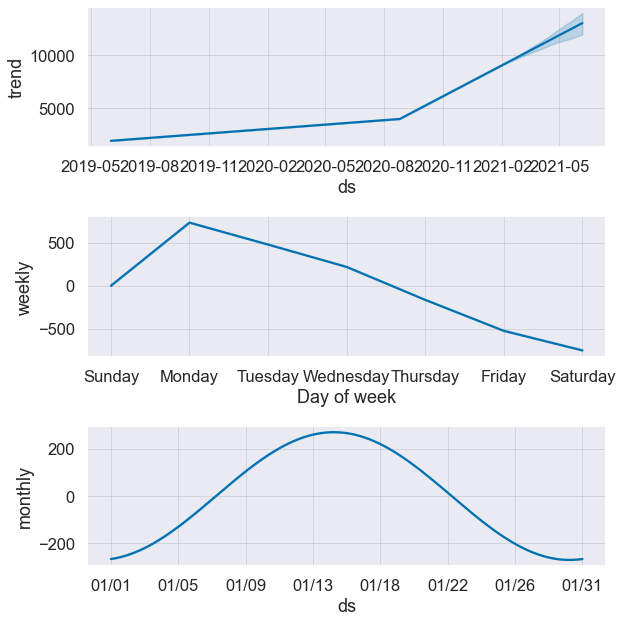

In [316]:
# ploting model components
model.plot_components(forecast)
plt.show()

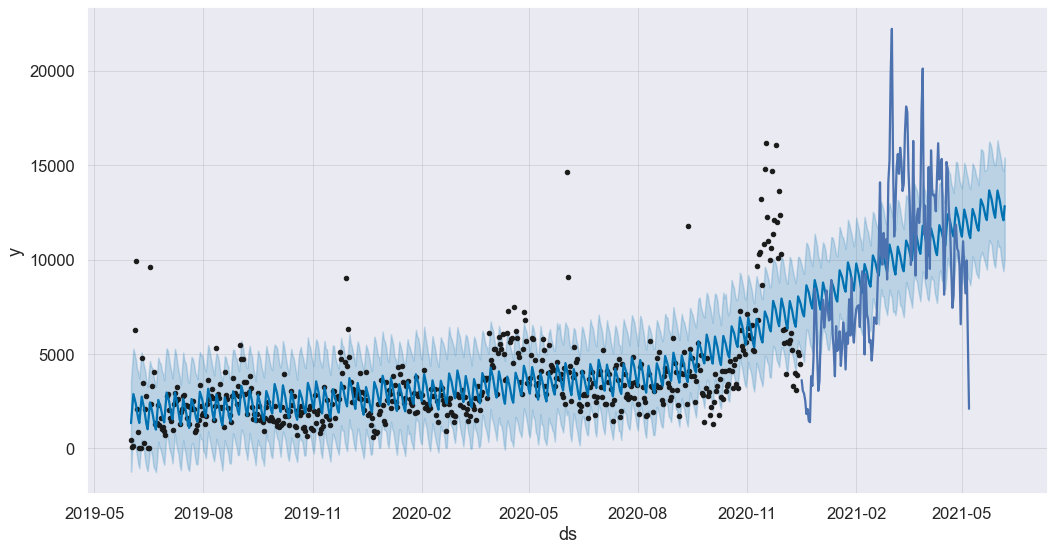

In [317]:
 # comparing Forecast to Actual

f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)


fig=model.plot(forecast, ax=ax)
ax.plot(test_df.ds, test_df.y)



Text(0.5, 1.0, 'One Month Forecast Vs Actual, March 1 to 30, 2021')

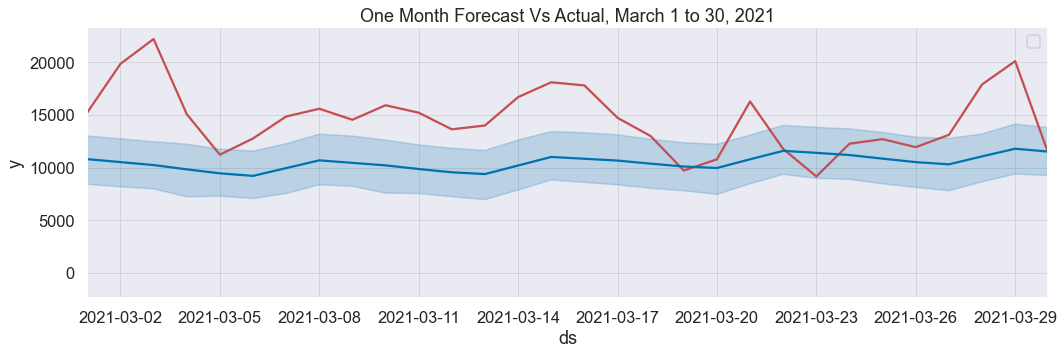

In [318]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = model.plot(forecast, ax=ax)
ax.set_xbound(lower='2021-03-01', upper='2021-03-30')
plt.legend()
plt.title('One Month Forecast Vs Actual, March 1 to 30, 2021')



Text(0.5, 1.0, 'One month Forecast Vs Actual, April 07 to May 6 , 2021')

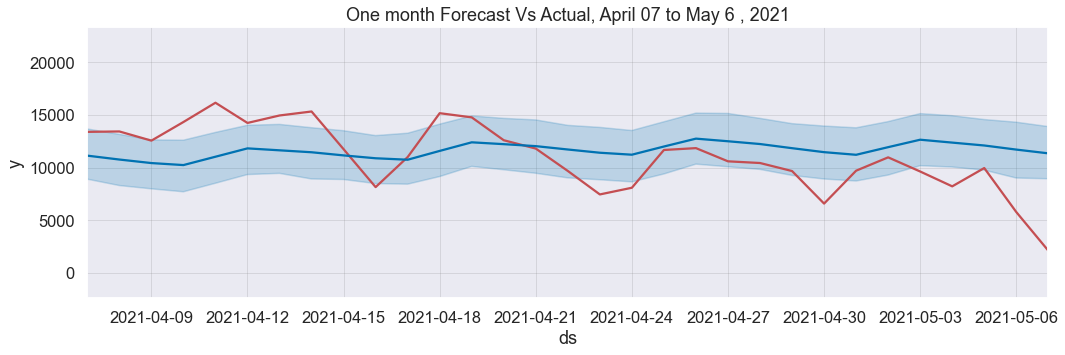

In [319]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = model.plot(forecast, ax=ax)
ax.set_xbound(lower='2021-04-07', upper='2021-05-07')

plt.title('One month Forecast Vs Actual, April 07 to May 6 , 2021')

Text(0.5, 1.0, 'One month Forecast, May 07 to June 6, 2021')

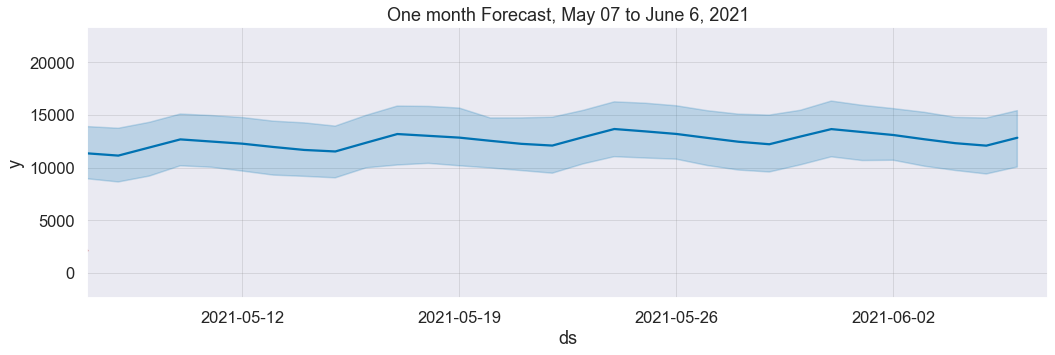

In [320]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = model.plot(forecast, ax=ax)
ax.set_xbound(lower='2021-05-07', upper='2021-06-07')

plt.title('One month Forecast, May 07 to June 6, 2021')

Text(0.5, 1.0, 'One week Forecast Vs Actual, March 19 to 25, 2021')

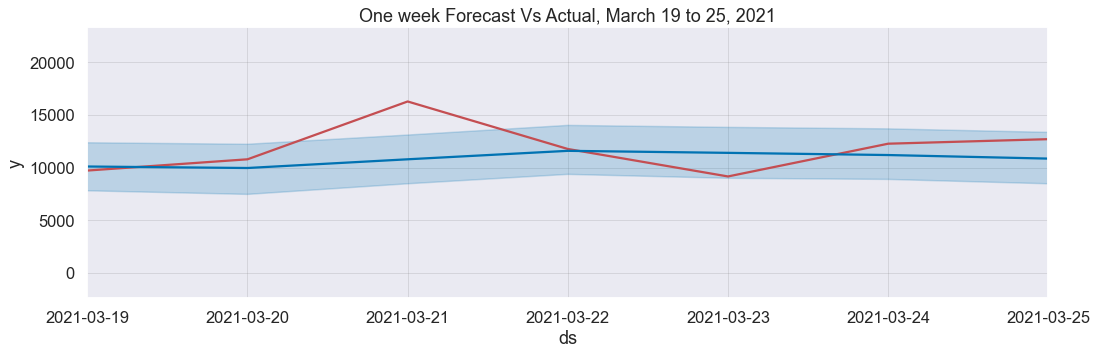

In [321]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = model.plot(forecast, ax=ax)
ax.set_xbound(lower='2021-03-19', upper='2021-03-25')

plt.title('One week Forecast Vs Actual, March 19 to 25, 2021')


In [322]:
# Means Squared Error and RSME
predictions=forecast.yhat[-142:]
mse=mean_squared_error(test_df.y, predictions)
rmse=sqrt(mean_squared_error(test_df.y, predictions))
print('MSE: ', mse)
print('RMSE: ', rmse)

#Mean absolute percentage error (mape)

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Cross Validation
df_cv=cross_validation(model, horizon='30 days', initial='90', period='30 days')

mape=mean_absolute_percentage_error(df_cv.y, df_cv.yhat)
print('MAPE: ', mape)

# https://www.kaggle.com/robikscube/time-series-forecasting-with-prophet

INFO:fbprophet:Making 18 forecasts with cutoffs between 2019-06-25 00:00:00 and 2020-11-16 00:00:00


MSE:  15674752.106285652
RMSE:  3959.1352725419288



MAPE:  47.73128443060113


In [323]:
df_cv.head()


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-06-26,3141.175,331.428,5719.593,1603.947,2019-06-25
1,2019-06-27,1074.065,-1427.791,3935.907,1052.021,2019-06-25
2,2019-06-28,-333.167,-3176.155,2542.013,1136.940,2019-06-25
3,2019-06-29,-1996.915,-4915.706,787.314,941.732,2019-06-25
4,2019-06-30,-2301.889,-4996.316,621.664,702.544,2019-06-25


In [324]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
535,2020-12-12,4903.133,2779.829,6863.244,3106.638,2020-11-16
536,2020-12-13,5647.353,3676.870,7739.404,3908.385,2020-11-16
537,2020-12-14,6473.679,4483.083,8510.268,5127.620,2020-11-16
538,2020-12-15,6115.790,4164.040,7998.546,4938.945,2020-11-16
539,2020-12-16,5873.841,3873.426,7880.189,4451.310,2020-11-16


In [325]:
### Performance Metrics
from fbprophet.diagnostics import performance_metrics
df_perf = performance_metrics(df_cv)
df_perf

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,4877026.937,2208.399,1283.113,0.472,0.257,0.759
1,4 days,3177105.710,1782.444,1110.738,0.424,0.191,0.815
2,5 days,2931784.893,1712.246,1141.345,0.462,0.263,0.833
3,6 days,3981669.525,1995.412,1206.782,0.416,0.254,0.852
4,7 days,5318180.701,2306.118,1437.968,0.427,0.310,0.778
5,8 days,6144028.114,2478.715,1654.237,0.436,0.405,0.704
6,9 days,7265903.858,2695.534,1883.227,0.553,0.469,0.593
7,10 days,6695140.473,2587.497,1847.842,0.585,0.456,0.648
8,11 days,5925255.109,2434.185,1675.448,0.590,0.326,0.722
9,12 days,5485190.304,2342.048,1576.290,0.549,0.291,0.759


Text(0.5, 1.0, ' Forecast Vs Actual')

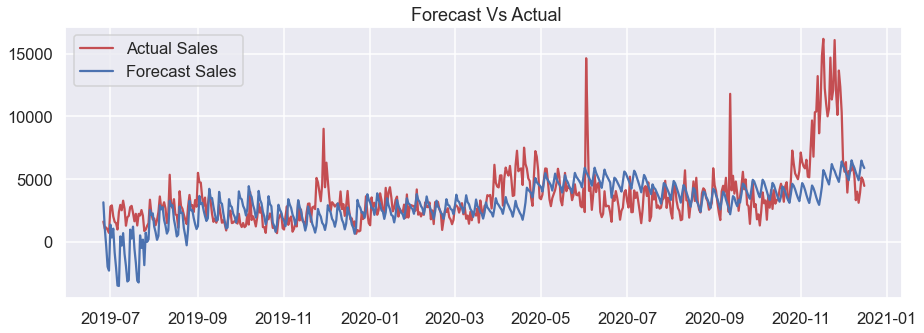

In [326]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(df_cv['ds'], df_cv['y'], color='r', label='Actual Sales')
ax.plot(df_cv['ds'], df_cv['yhat'], color='b', label='Forecast Sales')
plt.legend()



plt.title(' Forecast Vs Actual')

# Hyperparameter tuning

In [327]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [3, 6, 9, 12, 15, 18, 21, 24, 25, 30]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 500


In [328]:
import itertools
param_grid = {'seasonality_mode':('multiplicative','additive'),  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
             'n_changepoints' : [3, 6, 9, 12, 15, 18, 21, 24, 25, 30]}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    cutoffs=pd.to_datetime(['2020-03-03','2020-04-28'])
    m = Prophet(**params).fit(train_df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

#https://facebook.github.io/prophet/docs/diagnostics.html

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f834d95fee0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f837758c820>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f834dfead90>
INFO:fbprophet:Disabling yearly seaso

INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f83676e8070>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f835b04fb80>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f836b112cd0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel w

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f832d4d6f40>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f837758c820>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f83673fd820>
INFO:fbprophet:Disabling yearly seaso

INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f83ae1ad5e0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8366a05790>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f83764b18e0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel w

INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f834f39ebb0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f836b07c4f0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f836852d640>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel w

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8369b73430>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8359a9ec70>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f832d4d6f40>
INFO:fbprophet:Disabling yearly seaso

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f836852d5b0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f83685515b0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f832d4d6700>
INFO:fbprophet:Disabling yearly seaso

INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f836852d130>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f83b08a9fa0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f834d95fee0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel w

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f836958d700>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f83673fd7c0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8366a05790>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily season

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f83b08a9670>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f836852d760>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f834dfead90>
INFO:fbprophet:Disabling yearly seaso

INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f832f0d7dc0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f832f0d7dc0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f83ae1ad5e0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel w

INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f836b112cd0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f832d83a580>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8369b73430>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel w

INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f83338c5760>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f832d83aa90>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f83676cd400>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel w

    seasonality_mode  changepoint_prior_scale  seasonality_prior_scale  \
0     multiplicative                    0.001                    0.010   
1     multiplicative                    0.001                    0.010   
2     multiplicative                    0.001                    0.010   
3     multiplicative                    0.001                    0.010   
4     multiplicative                    0.001                    0.010   
..               ...                      ...                      ...   
315         additive                    0.500                   10.000   
316         additive                    0.500                   10.000   
317         additive                    0.500                   10.000   
318         additive                    0.500                   10.000   
319         additive                    0.500                   10.000   

     n_changepoints     rmse  
0                 3 1060.150  
1                 6 1277.222  
2                 

In [329]:

tuning_results.sort_values(by=['rmse'])

,seasonality_mode,changepoint_prior_scale,seasonality_prior_scale,n_changepoints,rmse
57,multiplicative,0.010,0.100,24,990.561
180,additive,0.001,1.000,3,999.507
206,additive,0.010,0.010,21,1005.267
56,multiplicative,0.010,0.100,21,1005.536
225,additive,0.010,1.000,18,1005.750
...,...,...,...,...,...
158,multiplicative,0.500,10.000,25,2005.777
134,multiplicative,0.500,0.100,15,2006.296
288,additive,0.500,0.010,25,2008.880
157,multiplicative,0.500,10.000,24,2020.753


In [330]:
final_model=Prophet(growth='linear', daily_seasonality=True, seasonality_mode='multiplicative', seasonality_prior_scale=0.10, changepoint_prior_scale=0.010, n_changepoints=24)
final_model.add_seasonality(name='monthly', period=30, fourier_order=1)
final_model.fit(train_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [331]:
future=final_model.make_future_dataframe(periods=test_df.shape[0]+30, freq='D')
final_forecast=final_model.predict(future)

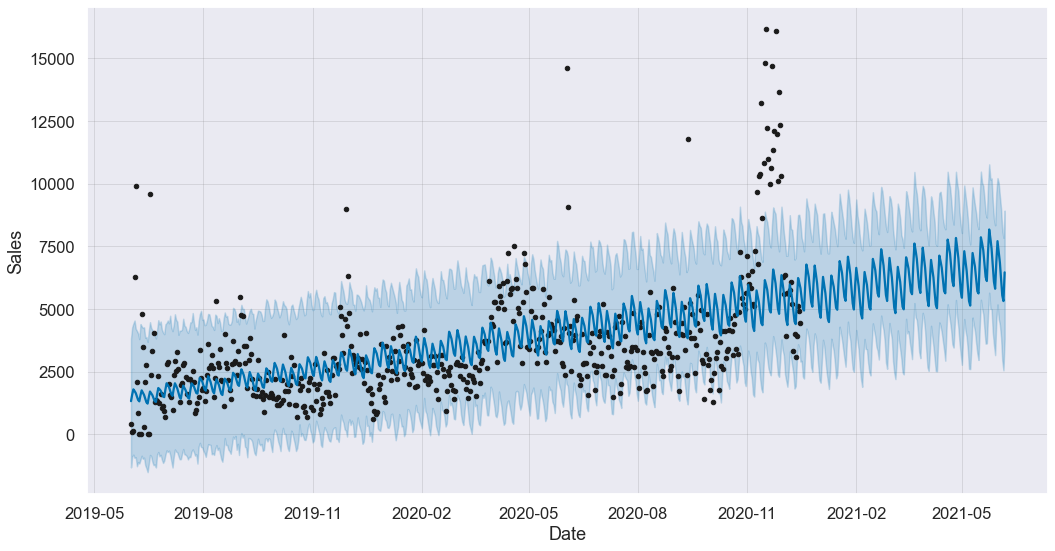

In [332]:
f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)

fig=final_model.plot(final_forecast, ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.show()

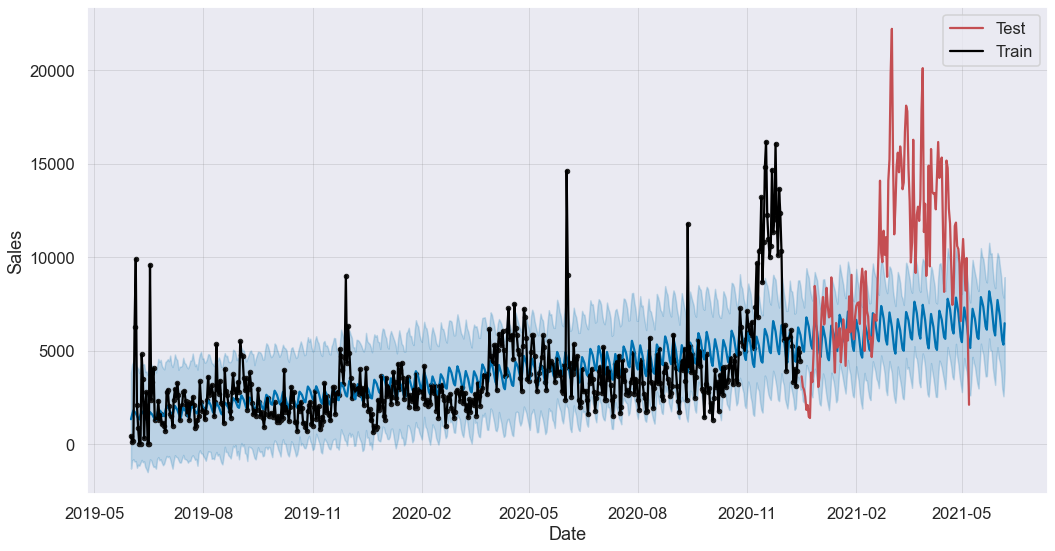

In [333]:
f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)


final_model.plot(final_forecast, ax=ax)
ax.plot(test_df.ds, test_df.y, color='r', label='Test')
ax.plot(train_df.ds, train_df.y, color='black', label='Train')
plt.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.show()

Text(0.5, 1.0, 'Forecast VS Actual Daily Sales')

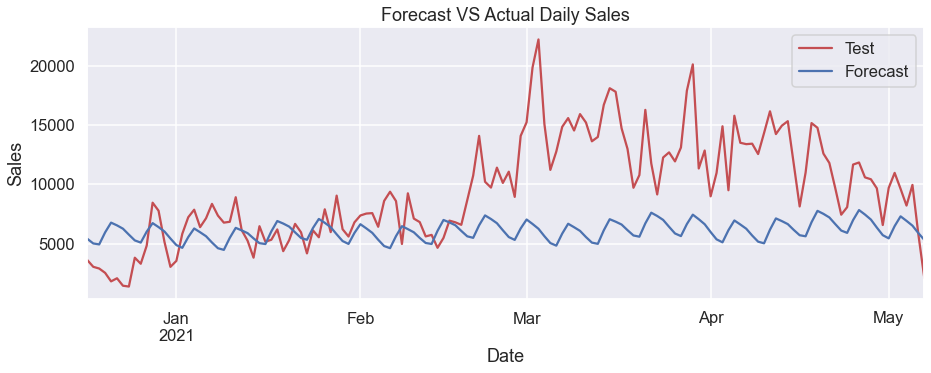

In [334]:
# Plot the forecast with the actuals
x_test_forecast=final_model.predict(test_df)

f, ax = plt.subplots(figsize=(14, 5))
f.set_figheight(5)
f.set_figwidth(15)
test_df.plot(x='ds', y='y', color='r', label='Test', ax=ax)
x_test_forecast.plot(x='ds', y='yhat', label='Forecast', ax=ax)
plt.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.title('Forecast VS Actual Daily Sales')

In [335]:
mape=mean_absolute_percentage_error(test_df.y, x_test_forecast.yhat)
print('MAPE: ', mape)

MAPE:  45.66586123198011


Text(0.5, 1.0, 'One month daily sales Forecast Vs Actual after model improvement, April 07 to May 6 , 2021')

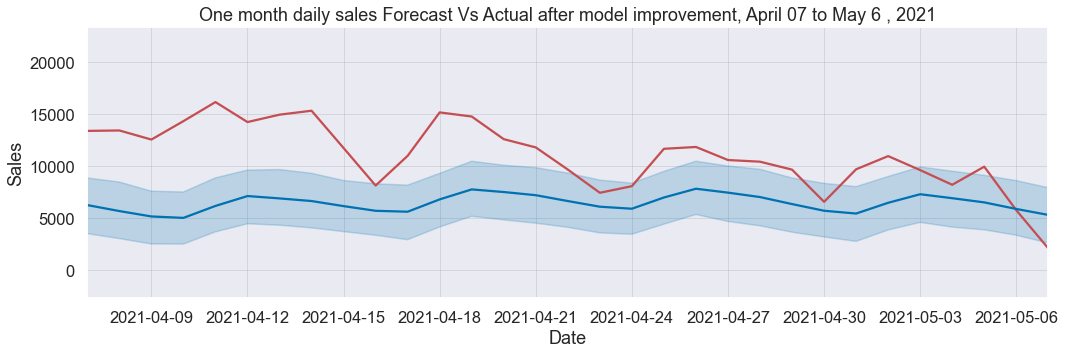

In [336]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = final_model.plot(final_forecast, ax=ax)
ax.set_xbound(lower='2021-04-07', upper='2021-05-07')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.title('One month daily sales Forecast Vs Actual after model improvement, April 07 to May 6 , 2021')

Text(0.5, 1.0, 'One week daily sales Forecast Vs Actual after model improvement, April 07 to May 6 , 2021')

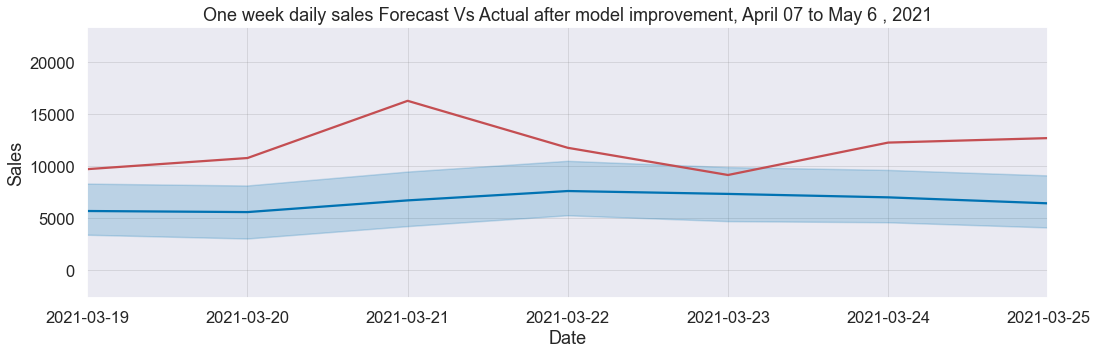

In [337]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = final_model.plot(final_forecast, ax=ax)
ax.set_xbound(lower='2021-03-19', upper='2021-03-25')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.title('One week daily sales Forecast Vs Actual after model improvement, April 07 to May 6 , 2021')

Text(0.5, 1.0, 'One month daily sales Forecast after model improvement, May 07 to June 6, 2021')

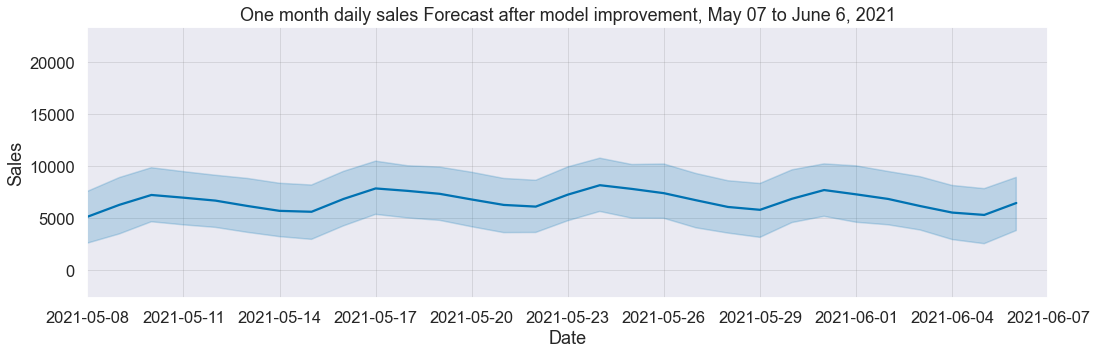

In [338]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = final_model.plot(final_forecast, ax=ax)
ax.set_xbound(lower='2021-05-08', upper='2021-06-07')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.title('One month daily sales Forecast after model improvement, May 07 to June 6, 2021')

In [339]:
forecast_one=forecast[['ds', 'yhat']]
forecast_two=final_forecast[['ds', 'yhat']]
forecast_one.columns=['ds', 'yhat_one']
forecast_two.columns=['ds', 'yhat_two']
forecast_combined=pd.merge(forecast_one, forecast_two, on='ds')
forecast_combined.head()

,ds,yhat_one,yhat_two
0,2019-06-01,1340.875,1326.895
1,2019-06-02,2124.869,1587.534
2,2019-06-03,2881.280,1796.655
3,2019-06-04,2639.780,1729.317
4,2019-06-05,2381.235,1649.035


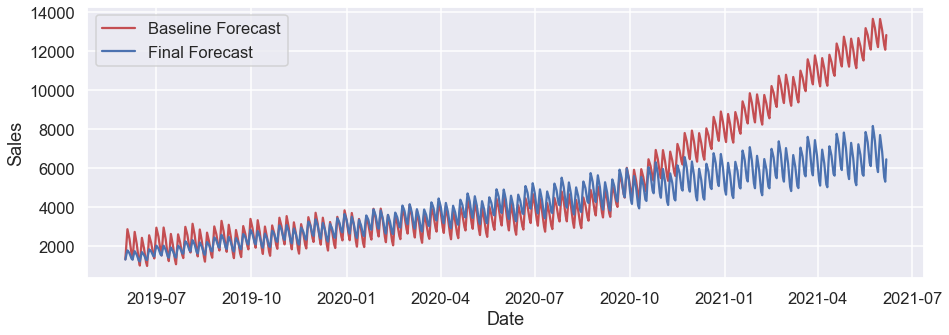

In [340]:
# Comparing the final forecast with the baseline forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(forecast_combined['ds'], forecast_combined['yhat_one'], color='r', label='Baseline Forecast')
ax.plot(forecast_combined['ds'], forecast_combined['yhat_two'], color='b', label='Final Forecast')

plt.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.show()

